In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
df_train = pd.read_csv("../data/raw/train.csv")
df_test = pd.read_csv("../data/raw/test.csv")

### Rename columns

In [6]:
# lower case column names
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [7]:
# rename columns to pythonic names
df_train = df_train.rename(columns={
    'passengerid': 'passenger_id',
    'survived': 'survived',
    'pclass': 'passenger_class',
    'sibsp': 'sibling_spouse_count',
    'parch': 'parent_child_count',
    'ticket': 'ticket_number',
    'embarked': 'embarked_port',
})

df_test = df_test.rename(columns={
    'passengerid': 'passenger_id',
    'survived': 'survived',
    'pclass': 'passenger_class',
    'sibsp': 'sibling_spouse_count',
    'parch': 'parent_child_count',
    'ticket': 'ticket_number',
    'embarked': 'embarked_port',
})

### Define unnecessary columns

In [8]:
cols_to_drop =['name', 'cabin', 'ticket_number', 'passenger_id']

In [9]:
# check column names
display(df_train.head())
display(df_test.head())

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,passenger_id,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Impute embarked values
Only two missing values, filled in with most common value

In [10]:
df_train["embarked_port"] = df_train["embarked_port"].fillna(df_train["embarked_port"].mode()[0])
df_test["embarked_port"] = df_test["embarked_port"].fillna(df_test["embarked_port"].mode()[0])

In [11]:
# check missing values
display(df_train.isnull().sum())
display(df_test.isnull().sum())

passenger_id              0
survived                  0
passenger_class           0
name                      0
sex                       0
age                     177
sibling_spouse_count      0
parent_child_count        0
ticket_number             0
fare                      0
cabin                   687
embarked_port             0
dtype: int64

passenger_id              0
passenger_class           0
name                      0
sex                       0
age                      86
sibling_spouse_count      0
parent_child_count        0
ticket_number             0
fare                      1
cabin                   327
embarked_port             0
dtype: int64

### Impute age values
Check correlation with age, grouped by columns with high correlation

In [12]:
# fill missing values in age column with grouped median
df_train["age"] = df_train["age"].fillna(df_train.groupby(["passenger_class", "sibling_spouse_count", "parent_child_count"])["age"].transform("median"))
df_test["age"] = df_test["age"].fillna(df_test.groupby(["passenger_class", "sibling_spouse_count", "parent_child_count"])["age"].transform("median"))
# fallback for remaining missing values fill with global age median
df_train["age"] = df_train["age"].fillna(df_train["age"].median())
df_test["age"] = df_test["age"].fillna(df_test["age"].median())

In [13]:
# check missing values
display(df_train['age'].isnull().sum())
display(df_test['age'].isnull().sum())

np.int64(0)

np.int64(0)

In [14]:
df_train.to_csv('../data/processed/train_cleaned.csv', index=False)
df_test.to_csv('../data/processed/test_cleaned.csv', index=False)

### Feature engineering

In [15]:
df_clean = pd.read_csv('../data/processed/train_cleaned.csv')

Binning

In [16]:
def survival_summary_by_feature(df, col):
    summary = (
        df.groupby(col)['survived']
        .agg(['count', 'mean'])
        .reset_index()
    )
 
    summary['survival_rate'] = (
        (summary['mean'] * 100)
        .round(1)
        .astype(int)
        .map(lambda x: f"{x}%")
    )
 
    return summary

In [17]:
# Find the cut-off age that best separates children from adults in terms of survival rate
scores = {}

for age in range(5, 21):
    is_child = (df_clean["age"] < age).astype(int)
    scores[age] = abs(df_clean.groupby(is_child)["survived"].mean().diff().iloc[-1])

best_age = max(scores, key=scores.get)
best_age, scores[best_age]

(7, np.float64(0.2792016806722689))

In [18]:
# Define age bins and laels
age_bins = [0, 13, 18, 30, 50, 100]
age_labels = ['child', 'teenager', 'young_adult', 'adult', 'senior']

In [19]:
df_clean["age_group"] = pd.cut(
    df_clean["age"],
    bins=age_bins,
    labels=age_labels
)

df_clean.groupby("age_group")["survived"].mean()
survival_summary_by_feature(df_clean, "age_group")

,age_group,count,mean,survival_rate
0,child,75,0.560000,56%
1,teenager,70,0.400000,40%
2,young_adult,400,0.325000,32%
3,adult,282,0.425532,42%
4,senior,64,0.343750,34%


In [20]:
df_clean.head()

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young_adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young_adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult


`fare_group`

In [21]:
df_clean.groupby('passenger_class')['fare'].describe()

,count,mean,std,min,25%,50%,75%,max
passenger_class,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


##### Conclusion by looking at 25%/50%/75% quartiles
- Most passenger_class 3 < 16
- Most passenger_class 2 13-28
- Most passenger_class 1 > 31

In [22]:
fare_bins =[0, 16, 30, df_clean['fare'].max()]
fare_labels = ['low', 'medium', 'high']
 
df_clean["fare_group"] = pd.cut(
    df_clean["fare"],
    bins=fare_bins,
    labels=fare_labels,
    include_lowest=True
)

In [23]:
survival_summary_by_feature(df_clean, "fare_group")

,fare_group,count,mean,survival_rate
0,low,485,0.263918,26%
1,medium,172,0.453488,45%
2,high,234,0.581197,58%


`family_group`

In [24]:
df_clean['family_size'] = df_clean['sibling_spouse_count'] + df_clean['parent_child_count'] + 1

In [25]:
survival_summary_by_feature(df_clean, "family_size")

,family_size,count,mean,survival_rate
0,1,537,0.303538,30%
1,2,161,0.552795,55%
2,3,102,0.578431,57%
3,4,29,0.724138,72%
4,5,15,0.200000,20%
5,6,22,0.136364,13%
6,7,12,0.333333,33%
7,8,6,0.000000,0%
8,11,7,0.000000,0%


In [26]:
family_size_bins =[0, 1, 4, 20]
family_size_labels = ['alone', 'small', 'large']

df_clean["family_group"] = pd.cut(
    df_clean["family_size"],
    bins=family_size_bins,
    labels=family_size_labels
)
 

In [27]:
survival_summary_by_feature(df_clean, "family_group")

,family_group,count,mean,survival_rate
0,alone,537,0.303538,30%
1,small,292,0.578767,57%
2,large,62,0.161290,16%


In [28]:
df_clean.head()

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group,fare_group,family_size,family_group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young_adult,low,2,small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,high,2,small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young_adult,low,1,alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,high,2,small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,low,1,alone


Extract `title`

In [29]:
# create new title column
df_clean["title"] = df_clean["name"].str.extract(r",\s*([^\.]+)\.", expand=False).str.strip()

In [30]:
title_map = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Other",
    "the Countess": "Other",
    "Dona": "Other",
    "Dr": "Other",
    "Rev": "Other",
    "Col": "Other",
    "Major": "Other",
    "Capt": "Other",
    "Sir": "Other",
    "Jonkheer": "Other",
    "Don": "Other"
}
df_clean["title"] = df_clean["title"].replace(title_map)

In [31]:
df_clean["title"].value_counts()

title
Mr        517
Miss      185
Mrs       126
Master     40
Other      23
Name: count, dtype: int64

In [32]:
df_clean.head()

,passenger_id,survived,passenger_class,name,sex,age,sibling_spouse_count,parent_child_count,ticket_number,fare,cabin,embarked_port,age_group,fare_group,family_size,family_group,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,young_adult,low,2,small,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,adult,high,2,small,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,young_adult,low,1,alone,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,adult,high,2,small,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,adult,low,1,alone,Mr


In [33]:
survival_summary_by_feature(df_clean, "title")

,title,count,mean,survival_rate
0,Master,40,0.575000,57%
1,Miss,185,0.702703,70%
2,Mr,517,0.156673,15%
3,Mrs,126,0.793651,79%
4,Other,23,0.347826,34%


### One-hot encoding

In [34]:
cols_to_one_hot_encode = ['title', 'age_group', 'fare_group', 'family_group', 'embarked_port']

# One-hot encode the specified columns
df_clean = pd.get_dummies(
    df_clean,
    columns=cols_to_one_hot_encode,
    dtype=int,
    drop_first=False
)

# Check the new columns
df_clean.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   passenger_id           891 non-null    int64  
 1   survived               891 non-null    int64  
 2   passenger_class        891 non-null    int64  
 3   name                   891 non-null    str    
 4   sex                    891 non-null    str    
 5   age                    891 non-null    float64
 6   sibling_spouse_count   891 non-null    int64  
 7   parent_child_count     891 non-null    int64  
 8   ticket_number          891 non-null    str    
 9   fare                   891 non-null    float64
 10  cabin                  204 non-null    str    
 11  family_size            891 non-null    int64  
 12  title_Master           891 non-null    int64  
 13  title_Miss             891 non-null    int64  
 14  title_Mr               891 non-null    int64  
 15  title_Mrs        

### Binary encode sex to numeric values

In [35]:
print(f"sex before: {df_clean['sex'].unique().tolist()}")
df_clean["is_female"] = df_clean["sex"].map({"male": 0, "female": 1})
print(f"is_female after:  {df_clean['is_female'].unique().tolist()}")
 

sex before: ['male', 'female']
is_female after:  [0, 1]


Define engineering decisions
- Age bins:
    - child: 0–13
    - teenager: 14–18
    - young_adult: 19–30
    - adult: 31–50
    - senior: 50-100
- Fare bins:
    - low: 0–16
    - mid: 17–30
    - high: 30+
- Family group:
    - alone: 1
    - small: 2–4
    - large: 5+
- Title grouping:
    - Mr
    - Mrs
    - Miss
    - Master
    - Other

In [36]:
# Define bins and labels
AGE_BINS = [0, 13, 18, 30, 50, 100]
AGE_LABELS = ['child', 'teenager', 'young_adult', 'adult', 'senior']

FARE_BINS =[0, 16, 30, df_clean['fare'].max()]
FARE_LABELS = ['low', 'medium', 'high']

FAMILY_SIZE_BINS =[0, 1, 4, 20]
FAMILY_SIZE_LABELS = ['alone', 'small', 'large']

In [41]:
def feature_engineering(df):
    df = df.copy()

    # Create age groups
    df['age_group'] = pd.cut(df['age'], bins=AGE_BINS, labels=AGE_LABELS)

    # Create fare groups
    df['fare_group'] = pd.cut(df['fare'], bins=FARE_BINS, labels=FARE_LABELS)

    # Create family size groups
    df['family_size'] = df['sibsp'] + df['parch'] + 1  # +1 to include the passenger themselves
    df['family_group'] = pd.cut(df['family_size'], bins=FAMILY_SIZE_BINS, labels=FAMILY_SIZE_LABELS)

    # Extract title from name
    df['title'] = df['name'].str.extract(r',\s*([^\.]+)\.')

    # Standardise titles
    df['title'] = df['title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Sir': 'Mr'})

    # Group other titles
    rare_titles = ['Lady', 'the Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona']
    df['title'] = df['title'].replace(rare_titles, 'other')

    return df

### Columns to keep

In [38]:
cols_to_keep = ['survived', 'passenger_class', 'is_female']

cols_to_keep += [col for col in df_clean.columns if col.startswith((
    'title_',
    'fare_group_',
    'age_group_',
    'family_group_',
    'embarked_port_'
))]

df_model = df_clean[cols_to_keep]

#### Sanity check

In [39]:
df_model.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   survived               891 non-null    int64
 1   passenger_class        891 non-null    int64
 2   is_female              891 non-null    int64
 3   title_Master           891 non-null    int64
 4   title_Miss             891 non-null    int64
 5   title_Mr               891 non-null    int64
 6   title_Mrs              891 non-null    int64
 7   title_Other            891 non-null    int64
 8   age_group_child        891 non-null    int64
 9   age_group_teenager     891 non-null    int64
 10  age_group_young_adult  891 non-null    int64
 11  age_group_adult        891 non-null    int64
 12  age_group_senior       891 non-null    int64
 13  fare_group_low         891 non-null    int64
 14  fare_group_medium      891 non-null    int64
 15  fare_group_high        891 non-null    int64
 16  f

## Models

#### `X, y` split

In [42]:
X = df_model.drop(columns='survived')
X.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   passenger_class        891 non-null    int64
 1   is_female              891 non-null    int64
 2   title_Master           891 non-null    int64
 3   title_Miss             891 non-null    int64
 4   title_Mr               891 non-null    int64
 5   title_Mrs              891 non-null    int64
 6   title_Other            891 non-null    int64
 7   age_group_child        891 non-null    int64
 8   age_group_teenager     891 non-null    int64
 9   age_group_young_adult  891 non-null    int64
 10  age_group_adult        891 non-null    int64
 11  age_group_senior       891 non-null    int64
 12  fare_group_low         891 non-null    int64
 13  fare_group_medium      891 non-null    int64
 14  fare_group_high        891 non-null    int64
 15  family_group_alone     891 non-null    int64
 16  f

In [43]:
y = df_model['survived']
y.info()

<class 'pandas.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: survived
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 7.1 KB


#### Pipelines

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg_pipeline = Pipeline([
    ('logistic_regression', LogisticRegression(max_iter=1000))
])

In [47]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None))
])

#### Test/train split

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#### Sanity check

In [45]:
print(X_train.shape)
print(X_test.shape)

(712, 21)
(179, 21)


In [49]:
print("Original:", y.mean())
print("Train:", y_train.mean())
print("Validation:", y_test.mean())

Original: 0.3838383838383838
Train: 0.37640449438202245
Validation: 0.4134078212290503


#### Train and evaluate models

##### Fit Logistic Regression

In [51]:
# Fit on training data
log_reg_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('logistic_regression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool

In [52]:
# Predictions
y_pred_log_reg = log_reg_pipeline.predict(X_test)

Logistic Regression Accuracy:
 0.8156
Confusion Matrix:
 [[97 13]
 [20 49]]


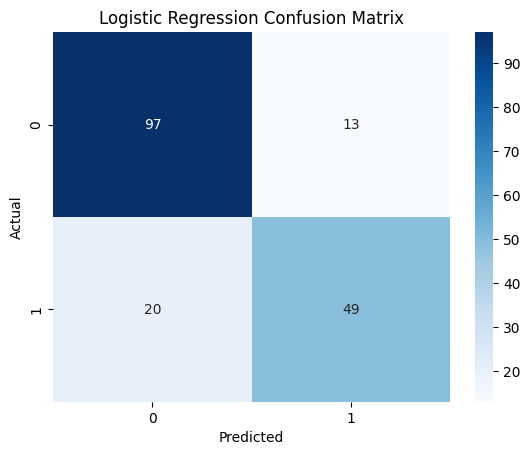

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Accuracy
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy:\n {accuracy_log_reg:.4f}")

# Confusion Matrix
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print(f"Confusion Matrix:\n {conf_matrix_log_reg}")
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
class_report_log_reg = classification_report(y_test, y_pred_log_reg)
print("Logistic Regression Classification Report:\n", class_report_log_reg)

In [56]:
# Fit on training data
rf_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('random_forest', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each spl

In [57]:
# Predictins
y_pred_rf = rf_pipeline.predict(X_test)

Random Forest Accuracy:
 0.7932960893854749
Confusion Matrix:
 [[94 16]
 [21 48]]


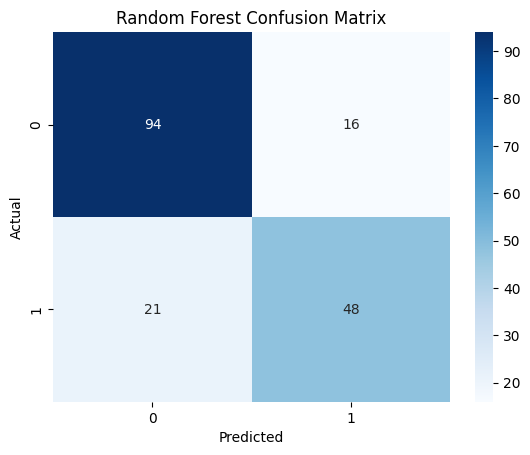

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       110
           1       0.75      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



In [58]:
# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:\n", acc_rf)

# Confusion Matrix
confusin_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", confusin_matrix_rf)
sns.heatmap(confusin_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

#### Fit KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
 
# train model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
 
# predict
y_prediction =  knn_model.predict(X_test)
accuracy=  accuracy_score(y_test, y_prediction)
 
print(f'Accuracy without scaling: {accuracy}')

Accuracy without scaling: 0.8044692737430168


In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
 
# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
 
# train model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
 
# predict
y_prediction =  knn_model.predict(X_test_scaled)
 
# accuracy
accuracy=  accuracy_score(y_test, y_prediction)
 
print(f'Accuracy with scaling: {accuracy}')

Accuracy with scaling: 0.7821229050279329


Random Forest Accuracy:
 0.5251396648044693
Confusion Matrix:
 [[69 41]
 [44 25]]


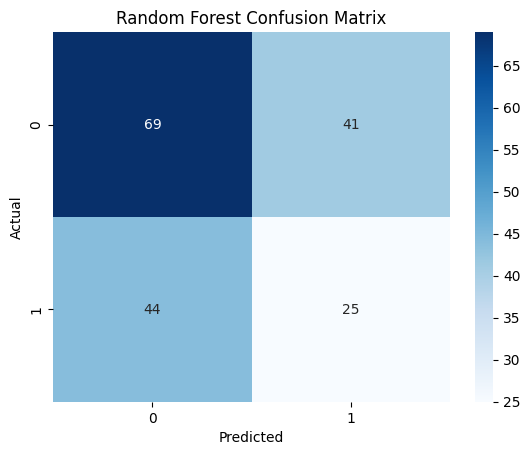

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.63      0.62       110
           1       0.38      0.36      0.37        69

    accuracy                           0.53       179
   macro avg       0.49      0.49      0.49       179
weighted avg       0.52      0.53      0.52       179



In [69]:
# Accuracy
acc_rf = accuracy_score(y_test, y_prediction)
print("Random Forest Accuracy:\n", acc_rf)

# Confusion Matrix
confusin_matrix_rf = confusion_matrix(y_test, y_prediction)
print("Confusion Matrix:\n", confusin_matrix_rf)
sns.heatmap(confusin_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_prediction))

In [67]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    knn_model,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean()}")

Cross-validation Accuracy Scores: [0.77653631 0.78651685 0.82022472 0.80898876 0.83707865]
Mean Cross-validation Accuracy: 0.8058690603226415


### Finalise the model

In [71]:
final_model = Pipeline([
    ('model', LogisticRegression(max_iter=1000))
])

final_model.fit(X, y)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=True

### Cross validate

In [72]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    final_model,
    X,
    y,
    cv=5,
    scoring='accuracy'
)

print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-validation Accuracy: {cv_scores.mean()}")

Cross-validation Accuracy Scores: [0.83240223 0.8258427  0.82022472 0.80898876 0.84831461]
Mean Cross-validation Accuracy: 0.827154604230745


#### Save the model

In [73]:
import joblib

joblib.dump(final_model, '../titanic_model.pkl')

['../titanic_model.pkl']

#### Sanity check

In [74]:
loaded_model = joblib.load('../titanic_model.pkl')
loaded_model.predict(X.iloc[:5])

array([0, 1, 1, 1, 0])